In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms 
import torchvision.models as models
import copy

## Data loader

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = (256, 256)

# scale imported image + transform it into a torch tensor
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])  

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    # fake batch dimension required to fit network's input dimensions 
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("Style/chuanghua.png")
content_img = image_loader("content/thor.jpeg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

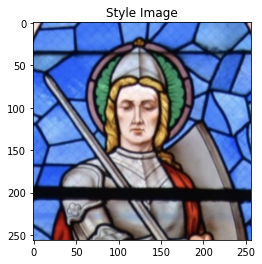

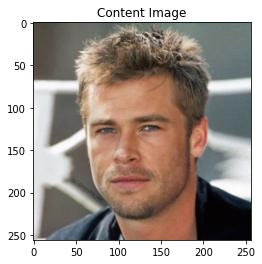

In [27]:
unloader = transforms.ToPILImage() # reconvert into PIL image
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone() # we clone the tensor to not do changes on it 
    image = image.squeeze(0) # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss Function

In [6]:
# content loss
class ContentLoss(nn.Module):
    def __init__(self, target,): 
        super(ContentLoss, self).__init__() 
        self.target = target.detach()
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target) 
        return input


# style loss
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d) 
    G = torch.mm(features, features.t()) 
    gram = G.div(a * b * c * d)
    return gram

class StyleLoss(nn.Module):
    def __init__(self, target): 
        super(StyleLoss, self).__init__() 
        self.target = target.detach()
    def forward(self, input):
        ## -- ! code required
        G = gram_matrix(input)
        A = gram_matrix(self.target) 
        self.loss = F.mse_loss(G, A) 
        return input

## Pre-trained model

In [7]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [8]:
# normalize image before send it to network

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()    
        self.mean = mean.clone().detach()
        self.std = std.clone().detach()

    def forward(self, img):
        # normalize img
        self.mean = torch.tensor(self.mean).view(-1, 1, 1)
        self.std = torch.tensor(self.std).view(-1, 1, 1)
        normalized_img = (img - self.mean) / self.std
        return normalized_img

## Get content/style representations

In [9]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, content_layers, style_layers):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss: 
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
            
            
        if name in style_layers:
            # add style loss:
            ## -- ! code required 
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            
            

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]
    return model, style_losses, content_losses

## Build model

In [10]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1,
                       content_layers=content_layers_selected,
                       style_layers=style_layers_selected):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, content_layers, style_layers)

    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.1, eps=1e-1)

    
    print('Optimizing..')
    step_i = 0
    while step_i <= num_steps:
        
        input_img.data.clamp_(0, 1)  
        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0
     
        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()
        optimizer.step()

        step_i += 1
        if step_i % 50 == 0:
            print("run {}:".format(step_i))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            print()
            
            
        
        

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

## Test

Building the style transfer model..


<ipython-input-8-cec1fe76953a>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(self.mean).view(-1, 1, 1)
<ipython-input-8-cec1fe76953a>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(self.std).view(-1, 1, 1)


Optimizing..
run 50:
Style Loss : 131288113627529216.000000 Content Loss: 26.603336

run 100:
Style Loss : 16766050158772224.000000 Content Loss: 26.148058

run 150:
Style Loss : 8854750464311296.000000 Content Loss: 26.333134

run 200:
Style Loss : 5925159714160640.000000 Content Loss: 26.510426

run 250:
Style Loss : 4374043012628480.000000 Content Loss: 26.670773

run 300:
Style Loss : 3430689684848640.000000 Content Loss: 26.815678



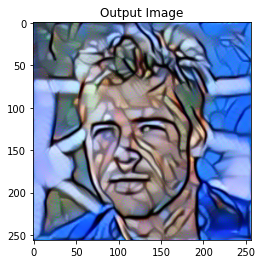

In [28]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

style_weight=1e20
input_img = content_img.clone().detach().requires_grad_(True)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=300,style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()